<a href="https://colab.research.google.com/github/andika-debug/repo/blob/main/Task_3_Feature_Engineering_%26_Data_Processing_within_2_Datasets_training__ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Raw Data set E-commerce

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# memuat dataset pertama yaitu Dataset E-commerce dari data.csv
# Source dari Kaggle.
df_ec = pd.read_csv('data.csv', encoding='latin1')
df_ec.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df_ec.info()
df_ec.isna().sum()
# hal ini untul melihat info lebih terstruktu akan data colom serta melihat jika ada missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [6]:
df_ec = df_ec.dropna(subset=['CustomerID'])
df_ec['Description'] = df_ec['Description'].fillna('Unknown')
# Menghapus data transaksi yang tidak memiliki identitas pelanggan karena tidak dapat digunakan untuk analisis lanjutan.

In [7]:
df_ec.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


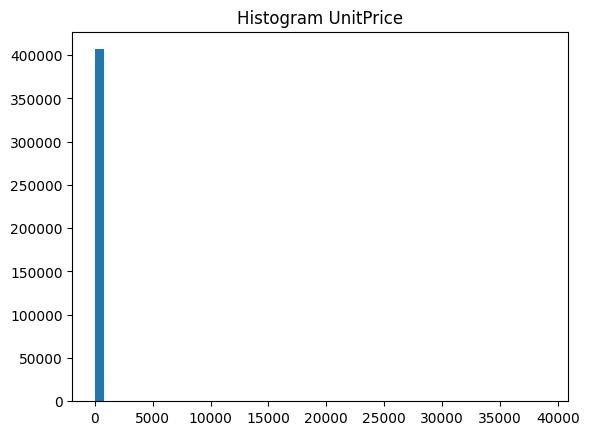

In [8]:
plt.hist(df_ec['UnitPrice'], bins=50)
plt.title('Histogram UnitPrice')
plt.show()

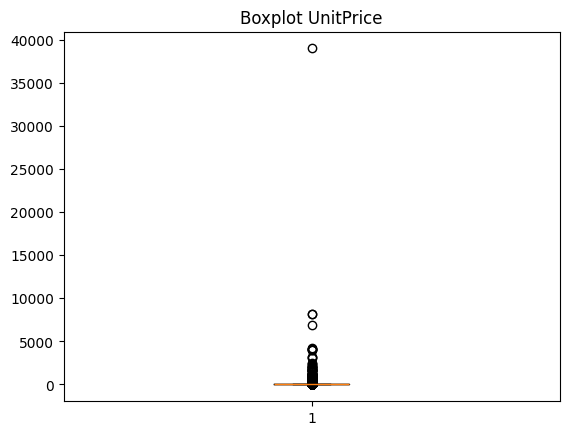

In [9]:
plt.boxplot(df_ec['UnitPrice'])
plt.title('Boxplot UnitPrice')
plt.show()

In [10]:
df_ec = df_ec[df_ec['Quantity'] > 0]
df_ec = df_ec[df_ec['UnitPrice'] > 0]
df_ec.duplicated().sum()

# Disini saya tidak menghapus data dupe karena untuk data transaksi itu sah saja seperti dimana adanya pelanggan yang membeli barang yang sama dengan waktu yang sama

np.int64(5192)

## Featuring Engineering
membuat variable baru + menata datetime from string agar bisa memakai function .dt untuk prosesi filtering cepat suatu dataset dengan datetime.

In [11]:
df_ec['TotalPrice'] = df_ec['Quantity'] * df_ec['UnitPrice']

In [12]:
df_ec['InvoiceDate'] = pd.to_datetime(df_ec['InvoiceDate'])

df_ec['InvoiceMonth'] = df_ec['InvoiceDate'].dt.month
df_ec['InvoiceDay'] = df_ec['InvoiceDate'].dt.day_name()
df_ec['InvoiceHour'] = df_ec['InvoiceDate'].dt.hour

In [13]:
df_ec['IsWeekend'] = df_ec['InvoiceDate'].dt.weekday >= 5

## Mengecek ulang datasetnya

In [14]:
df_ec.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPrice,0
InvoiceMonth,0


In [15]:
df_ec[['Quantity','UnitPrice','TotalPrice']].skew()

,0
Quantity,409.892972
UnitPrice,204.032727
TotalPrice,451.443182


## Split Train & Test
hal ini untuk mencegah data leakage

In [16]:
from sklearn.model_selection import train_test_split
y = df_ec['IsWeekend']
X = df_ec.drop(columns=['IsWeekend','InvoiceDate'])

In [24]:
# RESET dari sumber yang bersih
X = df_ec.drop(columns=[
    'IsWeekend',
    'InvoiceDate',
    'InvoiceNo',
    'StockCode',
    'Description'
])

y = df_ec['IsWeekend']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ['Country', 'InvoiceDay']

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

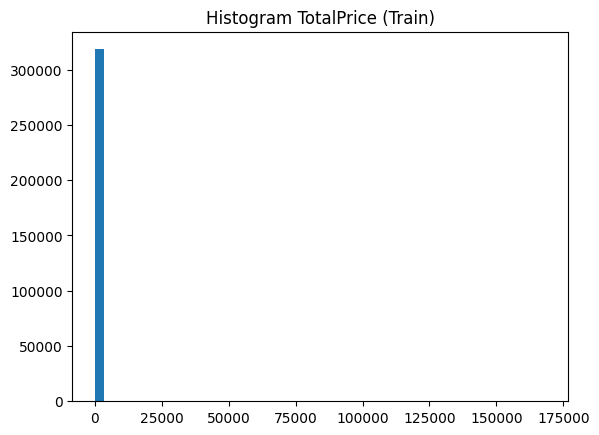

In [26]:
plt.hist(X_train['TotalPrice'], bins=50)
plt.title('Histogram TotalPrice (Train)')
plt.show()

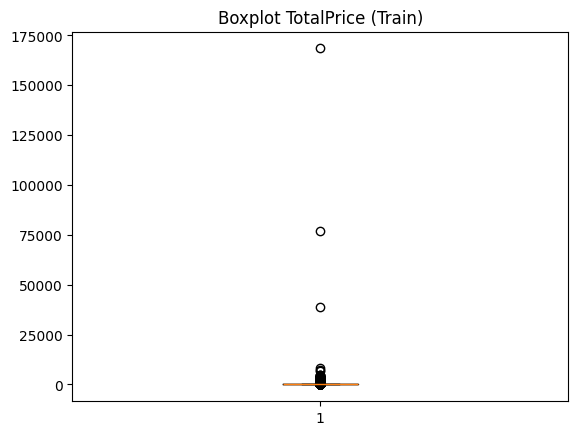

In [28]:
plt.boxplot(X_train['TotalPrice'])
plt.title('Boxplot TotalPrice (Train)')
plt.show()

## Modelling

In [30]:
from xgboost import XGBClassifier

In [32]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

In [34]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [35]:
from sklearn.metrics import accuracy_score, classification_report

In [37]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     67240
        True       1.00      1.00      1.00     12337

    accuracy                           1.00     79577
   macro avg       1.00      1.00      1.00     79577
weighted avg       1.00      1.00      1.00     79577



## Dataset Ke-2 | Medical Cost Personal

In [44]:
df_ins = pd.read_csv('insurance.csv', encoding='latin1')
df_ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [45]:
df_ins.info()
df_ins.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


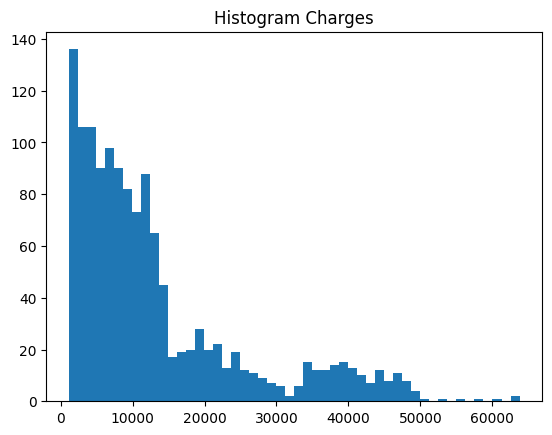

In [48]:
plt.hist(df_ins['charges'], bins=50)
plt.title('Histogram Charges')
plt.show()

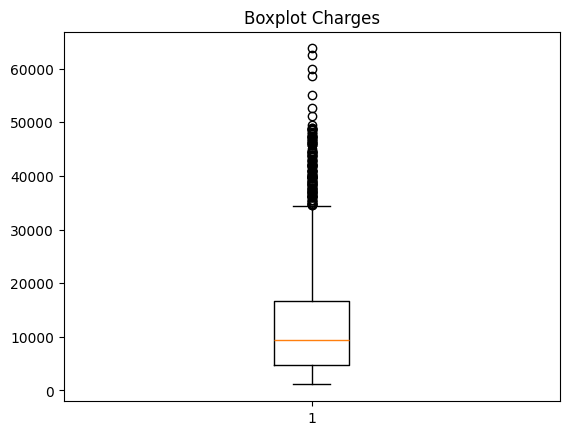

In [52]:
plt.boxplot(df_ins['charges'])
plt.title('Boxplot Charges')
plt.show()

In [55]:
df_ins['AgeGroup'] = pd.cut(
    df_ins['age'],
    bins=[0, 18, 35, 50, 65, 100],
    labels=['Teen', 'YoungAdult', 'Adult', 'Senior', 'Elder']
)

In [58]:
df_ins['BMICategory'] = pd.cut(
    df_ins['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

In [65]:
df_ins['Smoker_Age'] = df_ins['age'] * (df_ins['smoker'] == 'yes')

In [67]:
df_ins.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0
AgeGroup,0
BMICategory,0
Smoker_Age,0


In [70]:
df_ins[['age', 'bmi', 'charges']].skew()

,0
age,0.055673
bmi,0.284047
charges,1.515880


In [72]:
y = df_ins['charges']
X = df_ins.drop(columns=['charges'])

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [75]:
cat_cols = ['sex', 'smoker', 'region', 'AgeGroup', 'BMICategory']

In [76]:
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [77]:
X_train, X_test = X_train.align(
    X_test, join='left', axis=1, fill_value=0
)

In [79]:
from sklearn.preprocessing import StandardScaler

num_cols = ['age', 'bmi', 'Smoker_Age']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

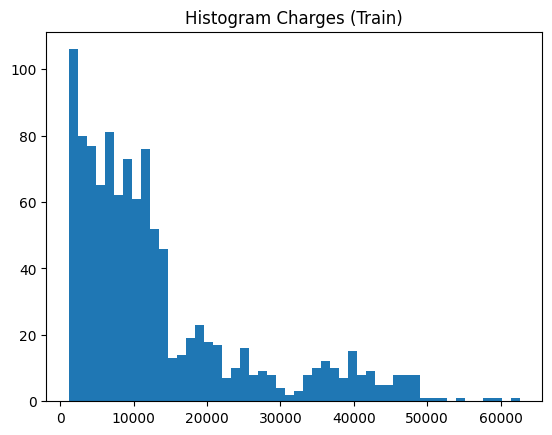

In [80]:
plt.hist(y_train, bins=50)
plt.title('Histogram Charges (Train)')
plt.show()

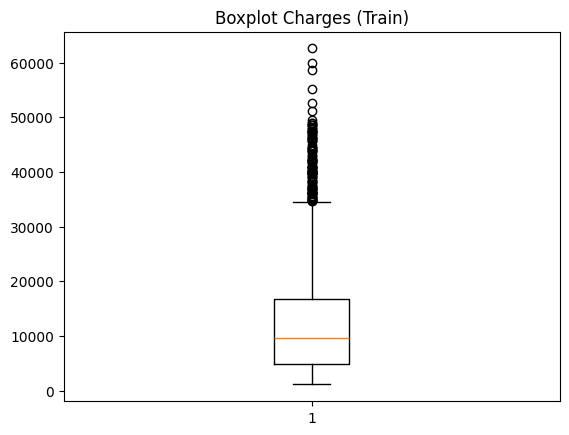

In [82]:
plt.boxplot(y_train)
plt.title('Boxplot Charges (Train)')
plt.show()

In [83]:
from xgboost import XGBRegressor

In [84]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

In [85]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2  :", r2_score(y_test, y_pred))

MAE : 2477.487880804629
RMSE: 4386.818066847022
R2  : 0.8760429630136128
